Load datasets and needed packages.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS
import seaborn as sns
Study_A = pd.read_csv('Study_A.csv')
Study_B = pd.read_csv('Study_B.csv')
Study_C = pd.read_csv('Study_C.csv')
Study_D = pd.read_csv('Study_D.csv')
Study_E = pd.read_csv('Study_E.csv')

In [4]:
study = pd.concat([Study_A, Study_B, Study_C, Study_D], axis = 0).reset_index().drop(columns = 'index')
study.head()

,Study,Country,PatientID,SiteID,RaterID,AssessmentiD,TxGroup,VisitDay,P1,P2,...,G9,G10,G11,G12,G13,G14,G15,G16,PANSS_Total,LeadStatus
0,A,USA,10001,20035,30076,100679,Control,0,5,5,...,5,3,3,4,3,3,3,5,107,Assign to CS
1,A,USA,10001,20035,30076,101017,Control,11,5,5,...,5,3,3,4,3,3,3,5,109,Assign to CS
2,A,USA,10001,20035,30076,102177,Control,18,4,4,...,4,2,2,3,3,2,3,4,91,Passed
3,A,USA,10001,20035,30076,101533,Control,25,3,3,...,3,2,2,3,3,2,3,4,80,Flagged
4,A,USA,10001,20035,30076,100930,Control,39,3,3,...,3,2,2,3,3,2,3,4,77,Flagged


Data cleaning. 
1. Check if there is missing values.
2. Check duplicates. i.e. If a patient was assessed multiple times on the same day.


In [5]:
study.isna().sum()
dup = study.groupby(['PatientID', 'VisitDay']).size().reset_index(name = 'counts')
dup = dup.loc[dup['counts'] > 1]
dup = dup.merge(study, on = ['PatientID', 'VisitDay'], how = 'inner')
study_dup = study.merge(dup, how = 'left', indicator = True)
study_dup = study_dup.loc[study_dup._merge == 'left_only'].drop(columns = '_merge')
dup['row_number'] = dup.groupby(['PatientID', 'VisitDay']).cumcount()+1
dup = dup.loc[dup['row_number'] == 1].drop(columns = ['counts', 'row_number'])
study = pd.concat([study_dup, dup], axis = 0).reset_index().drop(columns = ['index','counts'])

In [6]:
# Create summation of positive, negative, general scores.
study['PANSS_P'] = study.loc[:,'P1':'P7'].sum(axis = 1)
study['PANSS_N'] = study.loc[:,'N1':'N7'].sum(axis = 1)
study['PANSS_G'] = study.loc[:,'G1':'G16'].sum(axis = 1)


In [7]:
# Combining other observations, we can see three patients have error country info. We can fix the info for PatientID = 30040.
# For the other two patients, we need to drop their observations.
Patient_Country_Error = study.loc[study['Country'] == 'ERROR',].PatientID.unique()
Patient_True_Country = study[study['PatientID'].isin(Patient_Country_Error)].loc[study['Country'] != 'ERROR']
study.loc[study.PatientID == '30040', 'Country'] = 'USA'
study = study[(study.PatientID != '30177') & (study.PatientID != '30294')]


Now our data is clean. The final step before analysis is to drop unpredictive features 'SiteID', 'RaterID', 'AssessmentiD', 'Study', and create new feature 'relevant_visit_day' which holds more info than 'VisitDay'.
For goal 1-3, we only need valid assessments, i.e. LeadStatus = 'Passed'.

In [8]:
study = study.drop(columns = ['SiteID', 'RaterID', 'AssessmentiD', 'Study'])
study['relevant_visit_day'] = study.sort_values(['PatientID','VisitDay']).groupby(['PatientID']).cumcount() + 1
study_Passed = study[study.LeadStatus == 'Passed']

Now we can start the analysis.
Goal 1: detect the efficacy of this new medication.
For this goal, I would like to calculate the difference between the last visit day assessment score and day 0 assessment for each, and see if the difference is significantly less than 0.

In [9]:
# 1. select day 0 observations, and last visit day observations for each patient.
study_day0 = study_Passed[study_Passed.VisitDay == 0]
study_last_visit = study_Passed.sort_values(['PatientID', 'VisitDay'], ascending = [True, False]).groupby(['PatientID']).first().reset_index()

In [10]:
Patient_day0 = study_day0[['PatientID']]
Patient_last = study_last_visit[['PatientID']]
Patient_common = Patient_day0.merge(Patient_last)
study_last_visit = study_last_visit.merge(Patient_common)
Treatment_Effect = study_last_visit.merge(study_day0, on = ['PatientID', 'Country', 'TxGroup'])[['PatientID', 'Country', 'TxGroup', 'VisitDay_x', 'PANSS_Total_x', 'PANSS_Total_y', 'PANSS_P_x', 'PANSS_P_y', 'PANSS_N_x', 'PANSS_N_y', 'PANSS_G_x', 'PANSS_G_y']]
Treatment_Effect['diff_total'] = Treatment_Effect['PANSS_Total_x'] - Treatment_Effect['PANSS_Total_y']
Treatment_Effect['diff_P'] = Treatment_Effect['PANSS_P_x'] - Treatment_Effect['PANSS_P_y']                                                                        
Treatment_Effect['diff_N'] = Treatment_Effect['PANSS_N_x'] - Treatment_Effect['PANSS_N_y']                                                                        
Treatment_Effect['diff_G'] = Treatment_Effect['PANSS_G_x'] - Treatment_Effect['PANSS_G_y']                                                                        
Treatment_Effect = Treatment_Effect.rename(columns = {'VisitDay_x':'Day_diff'})
Treatment_Effect = Treatment_Effect.drop(Treatment_Effect.loc[:,'PANSS_Total_x':'PANSS_G_y'], axis = 1)                                                                             
                                                                             
                                                                             

Run linear regression to see if the difference is significantly less than 0. 
First encode all categorical variables.

In [22]:
from sklearn.linear_model import LinearRegression
Treatment_Effect_onehot = Treatment_Effect.copy()
Treatment_Effect_onehot = pd.get_dummies(Treatment_Effect_onehot, columns = ['Country', 'TxGroup'], prefix = ['Country', 'TxGroup'])

In [26]:
Treatment_Effect_X = Treatment_Effect[['Country', 'Day_diff', 'TxGroup']]
Treatment_Effect_X = pd.get_dummies(Treatment_Effect_X, columns = ['Country', 'TxGroup'], prefix = ['Country', 'TxGroup'])
Treatment_Effect_X = Treatment_Effect_X.drop(columns = ['Country_Ukraine', 'TxGroup_Control'])
Treatment_Effect_Y = Treatment_Effect[['diff_total']]
model = LinearRegression()
X = np.array(Treatment_Effect_X).reshape([-1, Treatment_Effect_X.shape[1]])
Y = np.array(Treatment_Effect_Y).reshape([-1, 1])
OLS(Y,X).fit().summary()
Y_P = np.array(Treatment_Effect[['diff_P']]).reshape([-1, 1])
Y_N = np.array(Treatment_Effect[['diff_N']]).reshape([-1, 1])
Y_G = np.array(Treatment_Effect[['diff_G']]).reshape([-1, 1])
OLS(Y_P,X).fit().summary()
OLS(Y_N,X).fit().summary()
OLS(Y_G,X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.635
Model:                            OLS   Adj. R-squared (uncentered):              0.629
Method:                 Least Squares   F-statistic:                              103.0
Date:                Mon, 05 Apr 2021   Prob (F-statistic):                        0.00
Time:                        11:58:43   Log-Likelihood:                         -6095.1
No. Observations:                1744   AIC:                                  1.225e+04
Df Residuals:                    1715   BIC:                                  1.241e+04
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0468      0.002    -29.970      0.000      -0.050      -0.044
x2            -7.9273      1.490     -5.319      0.000     -10.851      -5.004
x3            -1.4291      3.302     -0.433      0.665      -7.905       5.047
x4            -3.4803      4.024     -0.865      0.387     -11.374       4.413
x5            -3.1359      1.693     -1.853      0.064      -6.456       0.184
x6            -4.9120      1.476     -3.328      0.001      -7.807      -2.017
x7            -3.4479      1.349     -2.557      0.011      -6.093      -0.803
x8             1.2898      2.437      0.529      0.597      -3.490       6.070
x9            -3.3361      0.537     -6.211      0.000      -4.390      -2.283
x10            1.0307      1.041      0.990      0.322      -1.012       3.073
x11           -9.9301      5.697     -1.743      0.082     -21.104       1.244
x12            3.0095      2.683      1.122      0.262      -2.253       8.273
x13           -8.5291      1.869     -4.563      0.000     -12.195      -4.863
x14           -1.3093      2.244     -0.583      0.560      -5.711       3.093
x15           -3.9346      1.187     -3.314      0.001      -6.263      -1.606
x16           -1.6755      1.571     -1.067      0.286      -4.756       1.405
x17            1.9628      0.695      2.824      0.005       0.600       3.326
x18            1.2253      1.829      0.670      0.503      -2.361       4.812
x19           -6.2646      2.023     -3.097      0.002     -10.233      -2.297
x20            3.2235      1.097      2.937      0.003       1.071       5.376
x21           -6.9164      1.701     -4.067      0.000     -10.252      -3.581
x22            0.4580      1.573      0.291      0.771      -2.627       3.543
x23           -3.2231      0.630     -5.118      0.000      -4.458      -1.988
x24            2.9156      1.767      1.650      0.099      -0.550       6.382
x25            0.9415      1.472      0.639      0.523      -1.946       3.829
x26            8.1689      5.697      1.434      0.152      -3.005      19.343
x27            0.3833      1.909      0.201      0.841      -3.360       4.127
x28           -1.8217      0.461     -3.949      0.000      -2.727      -0.917
x29           -0.5268      0.377     -1.396      0.163      -1.267       0.213
==============================================================================
Omnibus:                       33.933   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.186
Skew:                          -0.019   Prob(JB):                     1.56e-15
Kurtosis:                       3.968   Cond. No.                     5.56e+03
=============================================================

X29 corresponds to the variable of interest: TxGroup. The results show that the coefficients of treatment indicator are negative for diff_total, diff_P, diff_N, diff_G but they are not statistically significant different from 0.

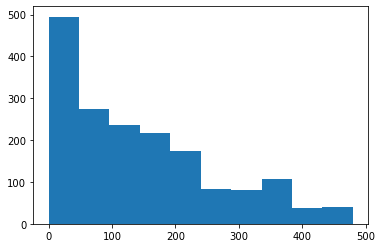

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.741
Model:                            OLS   Adj. R-squared (uncentered):              0.734
Method:                 Least Squares   F-statistic:                              104.7
Date:                Mon, 05 Apr 2021   Prob (F-statistic):                   4.44e-248
Time:                        11:47:29   Log-Likelihood:                         -3315.0
No. Observations:                 940   AIC:                                      6680.
Df Residuals:                     915   BIC:                                      6801.
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0343      0.002    -14.246      0.000      -0.039      -0.030
x2           -11.3847      1.923     -5.922      0.000     -15.158      -7.612
x3            -4.9491      4.229     -1.170      0.242     -13.248       3.350
x4            -3.6758      2.584     -1.423      0.155      -8.746       1.395
x5            -7.1181      1.877     -3.792      0.000     -10.802      -3.434
x6            -3.5085      3.204     -1.095      0.274      -9.796       2.779
x7            -7.4238      0.834     -8.901      0.000      -9.061      -5.787
x8            -1.0069      1.359     -0.741      0.459      -3.675       1.661
x9            -3.7823      4.831     -0.783      0.434     -13.262       5.698
x10          -11.0706      2.378     -4.655      0.000     -15.738      -6.403
x11           -4.4901      2.976     -1.509      0.132     -10.331       1.351
x12           -7.8631      1.738     -4.525      0.000     -11.273      -4.453
x13           -7.0090      2.020     -3.470      0.001     -10.973      -3.045
x14           -1.4730      1.046     -1.408      0.160      -3.527       0.581
x15           -2.2512      2.388     -0.943      0.346      -6.938       2.435
x16          -10.1135      2.436     -4.153      0.000     -14.893      -5.334
x17            0.5501      1.504      0.366      0.715      -2.402       3.502
x18          -13.9516      2.214     -6.302      0.000     -18.296      -9.607
x19           -4.3111      1.922     -2.243      0.025      -8.084      -0.538
x20           -6.5296      0.890     -7.341      0.000      -8.275      -4.784
x21           -0.0923      1.937     -0.048      0.962      -3.894       3.709
x22           -4.4914      2.115     -2.123      0.034      -8.643      -0.340
x23           -3.3052      2.692     -1.228      0.220      -8.588       1.977
x24           -3.5880      1.023     -3.506      0.000      -5.597      -1.579
x25           -0.9956      0.533     -1.867      0.062      -2.042       0.051
==============================================================================
Omnibus:                       33.518   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.023
Skew:                           0.257   Prob(JB):                     9.25e-14
Kurtosis:                       4.126   Cond. No.                     4.47e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.47e+03. This might indicate that there are
strong multicollinearit

In [14]:
plt.hist(Treatment_Effect_X.Day_diff)
plt.show()
# Repeat after dropping where Day_diff <= 100.
Treatment_Effect_X = Treatment_Effect[Treatment_Effect['Day_diff'] > 100][['Country', 'Day_diff', 'TxGroup']]
Treatment_Effect_X = pd.get_dummies(Treatment_Effect_X, columns = ['Country', 'TxGroup'], prefix = ['Country', 'TxGroup'])
Treatment_Effect_X = Treatment_Effect_X.drop(columns = ['Country_Ukraine', 'TxGroup_Control'])
Treatment_Effect_Y = Treatment_Effect[Treatment_Effect['Day_diff'] > 100][['diff_total']]
X = np.array(Treatment_Effect_X).reshape([-1, Treatment_Effect_X.shape[1]])
Y = np.array(Treatment_Effect_Y).reshape([-1, 1])
OLS(Y,X).fit().summary()
Y_P = np.array(Treatment_Effect[Treatment_Effect['Day_diff'] > 100][['diff_P']]).reshape([-1, 1])
Y_N = np.array(Treatment_Effect[Treatment_Effect['Day_diff'] > 100][['diff_N']]).reshape([-1, 1])
Y_G = np.array(Treatment_Effect[Treatment_Effect['Day_diff'] > 100][['diff_G']]).reshape([-1, 1])
OLS(Y_P,X).fit().summary()
OLS(Y_N,X).fit().summary()
OLS(Y_G,X).fit().summary()


After dropping patients whose last visit day is <= 100, model performance increased. Also, the coefficients for treatment indicator for diff_total, diff_P, diff_N, and diff_G are all statistically significant negative, meaning the medication is effective for patients who stayed in the experiment for more than 100 days.

Goal 2: Segment patients.
For this goal, we only need day 0 observations, which is contained in the data frame study_day0.
Since clustering methods such as k-means are based on distance, qualitative variables are not useful. The features used for clustering are assessment score P1 - P7, N1 - N7, and G1 - G16. 
We don't need to do scaling since they have the same magnitude.
Outliers won't be an issue since the sale for all score is 1-6.

K-means clustering doesn't do well on this dataset no matter we use sub scores or aggregated scores. The explanation is probably due to scores are normally distributed and hence not a good case for k-means clustering.

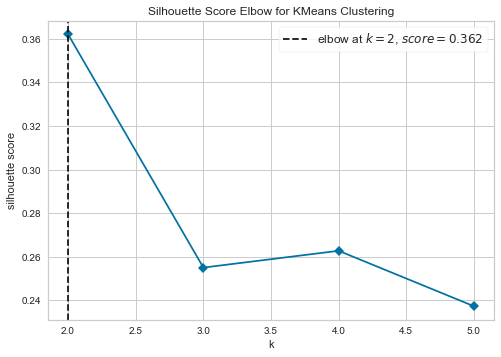

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=0)
# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,6), metric='silhouette', timings=False)
# Fit the data and visualize
cluster = study_day0.loc[:, 'P1':'G16']
cluster_total = study_day0.loc[:,'PANSS_P':'PANSS_G']
## Cluster based on aggregated scores.
visualizer.fit(cluster_total)    
visualizer.poof() 

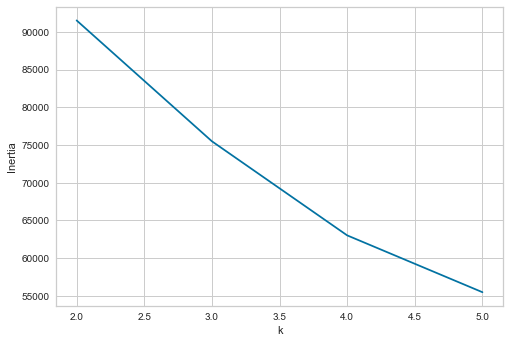

In [33]:
inertia = []
K = range(2,6)
for k in K:
    kMean = KMeans(n_clusters = k, init = 'random',
                   n_init = 10, max_iter = 300, 
                   tol = 1e-04, random_state = 0).fit(cluster_total)
    inertia.append(kMean.inertia_)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

We will use k = 4 to do the clustering.

In [34]:
kmean = KMeans(n_clusters = 4, init = 'random',
                   n_init = 10, max_iter = 300, 
                   tol = 1e-04, random_state = 0).fit(cluster_total)
label = pd.DataFrame(kmean.labels_)
cluster_total['label'] = label
cluster['label'] = label
cluster['PANSS_Total'] = cluster.loc[:,'P1':'G16'].sum(axis = 1)
cluster['PANSS_P'] = cluster.loc[:,'P1':'P7'].sum(axis = 1)
cluster['PANSS_N'] = cluster.loc[:,'N1':'N7'].sum(axis = 1)
cluster['PANSS_G'] = cluster.loc[:,'G1':'G16'].sum(axis = 1)

Plot the clustering to see if observations are well clustered.

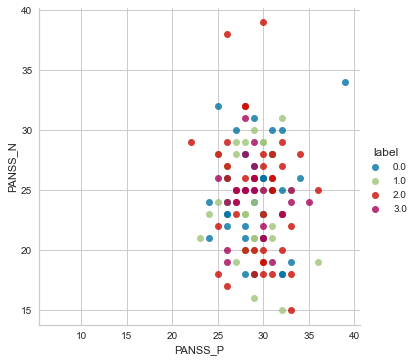

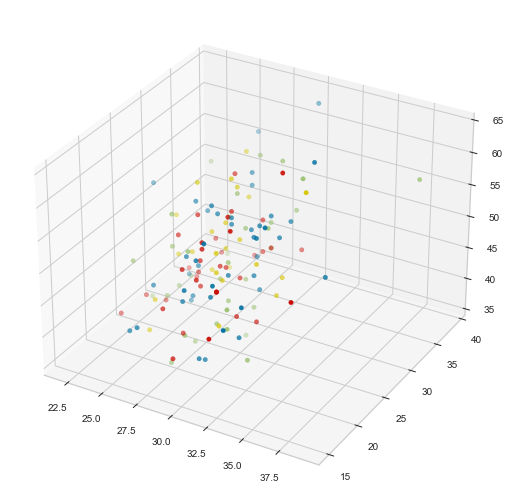

In [35]:
from mpl_toolkits import mplot3d
sns.lmplot(x='PANSS_P',y='PANSS_N',data=cluster_total,hue='label',fit_reg=False)
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection='3d')

ax.scatter3D(cluster_total[cluster_total['label'] == 0].PANSS_P, cluster_total[cluster_total['label'] == 0].PANSS_N, cluster_total[cluster_total['label'] == 0].PANSS_G, c = 'g')
ax.scatter3D(cluster_total[cluster_total['label'] == 1].PANSS_P, cluster_total[cluster_total['label'] == 1].PANSS_N, cluster_total[cluster_total['label'] == 1].PANSS_G, c = 'r')
ax.scatter3D(cluster_total[cluster_total['label'] == 2].PANSS_P, cluster_total[cluster_total['label'] == 2].PANSS_N, cluster_total[cluster_total['label'] == 2].PANSS_G, c = 'b')
ax.scatter3D(cluster_total[cluster_total['label'] == 3].PANSS_P, cluster_total[cluster_total['label'] == 3].PANSS_N, cluster_total[cluster_total['label'] == 3].PANSS_G, c = 'y')


Use TSNE to reduce dimensionality, and then plot the clustering.
The plots show that k-means doesn't cluster groups well.

In [40]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_obj= tsne.fit_transform(cluster_total.drop('label', axis = 1))
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'label':cluster_total.label})

<AxesSubplot:xlabel='X', ylabel='Y'>

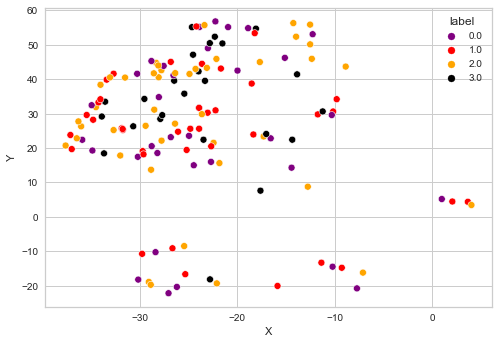

In [43]:
sns.scatterplot(x="X", y="Y",
              hue="label",
              palette=['purple','red', 'orange', 'black'],
              legend='full',
              data=tsne_df)

The summary statistics for each cluster do not show obvious difference.

In [49]:
cluster_total.groupby(['label'])[['PANSS_P', 'PANSS_N', 'PANSS_G']].mean()


,PANSS_P,PANSS_N,PANSS_G
label,,,
0.0,29.294118,24.705882,48.382353
1.0,28.820513,23.692308,47.846154
2.0,29.250000,24.522727,49.886364
3.0,29.083333,24.291667,51.083333


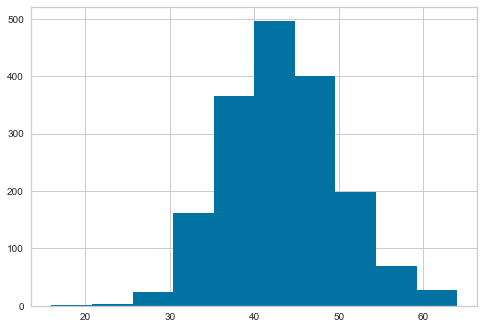

In [46]:
## Possible reason for k-means to fail the job is that we are clustering scores, which are generally normally distributed.
plt.hist(study_day0.PANSS_G)
plt.show()

Another way to segment the data using qualitative information is to classify patients based on their 'stay' status: if a patient dropped out before the end of the study.
We use study E for this segmentation since we can figure who stay or not for this study.

In [52]:
dup = Study_E.groupby(['PatientID', 'VisitDay']).size().reset_index(name = 'counts')
dup = dup.loc[dup['counts'] > 1].drop('counts', axis = 1)
dup = dup.merge(Study_E, on = ['PatientID', 'VisitDay'], how = 'inner')
study_E_dup = Study_E.merge(dup, how = 'left', indicator = True)
study_E_dup = study_E_dup.loc[study_E_dup._merge == 'left_only'].drop(columns = '_merge')
dup['row_number'] = dup.groupby(['PatientID', 'VisitDay']).cumcount()+1
dup = dup.loc[dup['row_number'] == 1].drop(columns = [ 'row_number'])
Study_E = pd.concat([study_E_dup, dup], axis = 0).reset_index().drop(columns = ['index'])

In [53]:
Study_E_day0 = Study_E[Study_E['VisitDay'] == 0]
Study_E_last_day = Study_E.sort_values(['PatientID', 'VisitDay'], ascending = [True, False]).groupby(['PatientID']).first().reset_index()
Study_E_last_day = Study_E_last_day[Study_E_last_day['VisitDay'] >= 159]
Study_E_last_day['stay'] = 1
Study_E_day0['stay'] = 0
replace = Study_E_day0.PatientID.isin(Study_E_last_day.PatientID)
Study_E_day0.loc[replace,'stay'] = 1
drop_out_patient = Study_E_day0[Study_E_day0.stay == 0][['PatientID']] 
last_day = Study_E.sort_values(['PatientID', 'VisitDay'], ascending = [True, False]).groupby(['PatientID']).first().reset_index()
search = last_day.PatientID.isin(drop_out_patient.PatientID)
drop_out_patient_last_day = last_day.loc[search][['VisitDay']]


<ipython-input-53-92912dd28608>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Study_E_day0['stay'] = 0
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


The histogram of the last VisitDay for patients who dropped out shows that about 40% of these patients dropped out early: within 40 days. About 25% of patients who dropped out dis that within 20 days.
We can build a classification model to find out predictive features for patients' 'stay' status.

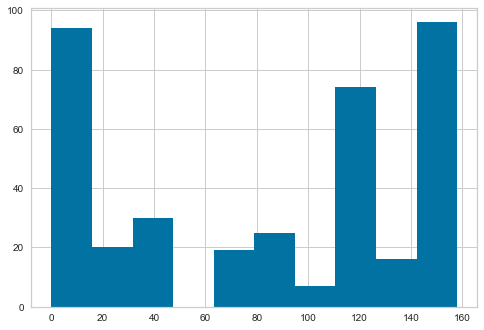

In [54]:
plt.hist(drop_out_patient_last_day.VisitDay)
plt.show()

In [55]:
Study_E_day0['PANSS_P'] = Study_E_day0.loc[:,'P1':'P7'].sum(axis = 1)
Study_E_day0['PANSS_N'] = Study_E_day0.loc[:,'N1':'N7'].sum(axis = 1)
Study_E_day0['PANSS_G'] = Study_E_day0.loc[:,'G1':'G16'].sum(axis = 1)
X = Study_E_day0[['Country', 'TxGroup', 'PANSS_P', 'PANSS_N', 'PANSS_G']]
X = pd.get_dummies(X, columns = ['Country', 'TxGroup'], prefix = ['Country', 'TxGroup'])
X = X.drop(columns = ['Country_USA', 'TxGroup_Control'])
Y = Study_E_day0[['stay']]


<ipython-input-55-54d7942ec10f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Study_E_day0['PANSS_P'] = Study_E_day0.loc[:,'P1':'P7'].sum(axis = 1)
<ipython-input-55-54d7942ec10f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Study_E_day0['PANSS_N'] = Study_E_day0.loc[:,'N1':'N7'].sum(axis = 1)
<ipython-input-55-54d7942ec10f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

From the report of logistic regression, we can see negative PANSS score and being in Russia are important for this segmentation. Yet the model fit is not good (accuracy = 0.76), considering that around 73% of patients didn't complete the experiment.

In [56]:
import statsmodels.api as sm 
log_reg = sm.Logit(Y, X).fit() 
log_reg.summary()
X = np.array(X).reshape([-1, X.shape[1]])
Y = np.array(Y).reshape([-1, 1])
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
lr = LogisticRegression(solver='newton-cg')
stay_cl = lr.fit(X, Y)
stay_cl.score(X, Y)
from sklearn.metrics import roc_auc_score
roc_auc_score(Y, stay_cl.decision_function(X))

Optimization terminated successfully.
         Current function value: 0.570193
         Iterations 6


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5659647657679153

Goal 3. Predict last visit PANSS_Total for study E.
For this goal, we first need to train a model predicting a patient's final visit PANSS_Total based on their previous assessments. A simple way is to use their second-last day assessment score as the approximate.

In [57]:
last_two = study_Passed.sort_values(['PatientID', 'VisitDay'], ascending = [True, False]).groupby(['PatientID']).head(2)
last_two['count'] = last_two.groupby(['PatientID'])['PatientID'].transform('count')
last_two['rank'] = last_two.sort_values(['PatientID', 'VisitDay']).groupby(['PatientID']).cumcount() + 1

In [58]:
last = last_two[last_two['rank'] == 2]
second_last = last_two[last_two['rank'] == 1]
prediction = last.merge(second_last, on = ['Country', 'PatientID', 'TxGroup'], how = 'inner')
prediction = prediction[['Country', 'PatientID', 'TxGroup', 'VisitDay_x', 'VisitDay_y', 'PANSS_Total_x', 'PANSS_Total_y', 'LeadStatus_x', 'LeadStatus_y']]
prediction = prediction[(prediction['LeadStatus_x'] == 'Passed') & (prediction['LeadStatus_y'] == 'Passed')]
prediction = prediction[prediction['VisitDay_x'] >= 126]

In [626]:
X = pd.get_dummies(prediction, columns = ['Country', 'TxGroup'], prefix = ['Country', 'TxGroup'])
X = X.drop(columns = ['PANSS_Total_x', 'Country_Ukraine', 'TxGroup_Control', 'VisitDay_x', 'PatientID', 'LeadStatus_x', 'LeadStatus_y'])
Y = prediction[['PANSS_Total_x']]
OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          PANSS_Total_x   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              2750.
Date:                Sun, 21 Mar 2021   Prob (F-statistic):                        0.00
Time:                        19:17:47   Log-Likelihood:                         -3472.9
No. Observations:                1033   AIC:                                      6998.
Df Residuals:                    1007   BIC:                                      7126.
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
VisitDay_y                 0.0016      0.002      0.735      0.462      -0.003       0.006
PANSS_Total_y              0.9662      0.011     85.608      0.000       0.944       0.988
Country_Argentina          2.6821      1.633      1.643      0.101      -0.522       5.886
Country_Australia          5.1858      3.232      1.604      0.109      -1.157      11.529
Country_Belgium            5.6617      2.321      2.439      0.015       1.107      10.217
Country_Bulgaria           1.5976      1.833      0.872      0.384      -1.999       5.194
Country_Canada            -0.1515      2.447     -0.062      0.951      -4.954       4.651
Country_China              0.5732      0.827      0.693      0.489      -1.050       2.196
Country_Czech Republic     4.7796      1.282      3.727      0.000       2.263       7.296
Country_France             3.3576      5.046      0.665      0.506      -6.544      13.259
Country_Germany            2.6358      2.125      1.240      0.215      -1.534       6.806
Country_Greece            -0.3266      2.768     -0.118      0.906      -5.758       5.105
Country_Hungary            0.9378      1.613      0.582      0.561      -2.227       4.102
Country_India              0.3845      1.441      0.267      0.790      -2.443       3.212
Country_Japan              4.1816      0.983      4.256      0.000       2.254       6.110
Country_Korea              1.5953      2.237      0.713      0.476      -2.795       5.986
Country_Mexico             0.9383      2.159      0.435      0.664      -3.298       5.175
Country_Poland             3.6684      1.420      2.583      0.010       0.881       6.455
Country_Portugal           2.3327      1.799      1.297      0.195      -1.197       5.863
Country_Romania            0.5267      1.793      0.294      0.769      -2.992       4.045
Country_Russia             0.5430      0.840      0.646      0.518      -1.106       2.192
Country_Slovakia           2.5537      1.711      1.492      0.136      -0.804       5.912
Country_Spain              3.0970      1.582      1.957      0.051      -0.008       6.202
Country_Taiwan             5.8576      2.219      2.640      0.008       1.503      10.212
Country_USA                3.0493      0.993      3.072      0.002       1.102       4.997
TxGroup_Treatment         -0.7278      0.440     -1.654      0.099      -1.592       0.136
==============================================================================
Omnibus:                      651.469   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9634.262
Skew:                           2.654   Prob(JB):                         0.00
Kurtosis:                    

See how our model does on validation data set.
RMSE on validation data set is 6.67, indicating our predicted PANSS_Total is on average 6.67 from their true value.

In [59]:
from sklearn.model_selection import train_test_split
X = np.array(X).reshape([-1, X.shape[1]])
Y = np.array(Y).reshape([-1, 1])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)
model = LinearRegression()
lm = model.fit(X_train, Y_train)
lm.score(X_train, Y_train)
lm.score(X_test, Y_test)
Y_pred = lm.predict(X_test)
RMSE = np.sqrt(np.square(Y_test - Y_pred).mean())

Goal 4. Classification of assessment errorneous. For this goal, we need to use all observations regardless of assessment flag.


In [60]:
from sklearn.metrics import log_loss
cls = study
cls['flag'] = 0
cls.loc[cls.LeadStatus != 'Passed', 'flag'] = 1
cls = cls[['TxGroup', 'VisitDay', 'PANSS_P', 'PANSS_N', 'PANSS_G', 'relevant_visit_day', 'flag']]
X = pd.get_dummies(cls, columns = ['TxGroup'])
X = X.drop(['TxGroup_Control', 'flag'], axis = 1)
Y = cls[['flag']]
im_balance = cls[cls.flag == 0].shape[0]/cls.shape[0]

Compared to data imbalance 0.76, the accuracy of 0.82 is not good.
Let's try random forest. Random forest with max-depth = 17 improves the model accuracy slightly better to 0.84, and test log loss improved from 0.42 to o.395.

In [64]:
lr = LogisticRegression(solver='newton-cg')
stay_cl = lr.fit(X, Y)
print(stay_cl.score(X, Y))
roc_auc_score(Y, stay_cl.decision_function(X))
Y_pred = stay_cl.predict_proba(X_test)
log_loss(Y_test, Y_pred)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8198397082113548


0.4190007210099748

In [65]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify = Y, test_size = 0.2)
score = []
for d in np.arange(2, 20, 1):
    cls = RandomForestClassifier(max_depth= d, random_state=0)
    rmf = cls.fit(X_train, Y_train)
    score.append([d, rmf.score(X_test, Y_test)])
print(score)
cls_best = RandomForestClassifier(max_depth= 17, random_state=0)
rmf_best = cls_best.fit(X_train, Y_train)
Y_pred = rmf_best.predict_proba(X_test)
log_loss(Y_test, Y_pred)

<ipython-input-65-b0ed24390d25>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rmf = cls.fit(X_train, Y_train)
<ipython-input-65-b0ed24390d25>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rmf = cls.fit(X_train, Y_train)
<ipython-input-65-b0ed24390d25>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rmf = cls.fit(X_train, Y_train)
<ipython-input-65-b0ed24390d25>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rmf = cls.fit(X_train, Y_train)
<ipython-input-65-b0ed24390d25>:6: DataConversionWarning: A column-vector y was passed when a 1d array w

[[2, 0.7581573896353166], [3, 0.7591170825335892], [4, 0.7675143953934741], [5, 0.7996641074856046], [6, 0.8097408829174664], [7, 0.8119001919385797], [8, 0.814299424184261], [9, 0.8186180422264875], [10, 0.8243761996161229], [11, 0.8279750479846449], [12, 0.8325335892514395], [13, 0.8358925143953935], [14, 0.8414107485604606], [15, 0.8394913627639156], [16, 0.8397312859884837], [17, 0.838531669865643], [18, 0.8399712092130518], [19, 0.8404510556621881]]


<ipython-input-65-b0ed24390d25>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rmf_best = cls_best.fit(X_train, Y_train)


0.39509512628568033